# **Installing the dependencies**

In [ ]:
!pip install opencv-python-headless pandas scikit-learn

# **Connecting google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading the dataset**

In [ ]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import pickle

# Set your images folder path in Google Drive
image_dir = Path('/content/drive/MyDrive/soil_data/images')

# **Segmentation,Estimating the moisture and performing auto labelling**

In [ ]:
def segment_soil(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_soil = np.array([10, 30, 30])
    upper_soil = np.array([30, 255, 255])
    mask = cv2.inRange(hsv, lower_soil, upper_soil)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

def extract_color_features(image, mask):
    soil_region = cv2.bitwise_and(image, image, mask=mask)
    hsv = cv2.cvtColor(soil_region, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(soil_region, cv2.COLOR_BGR2LAB)
    features = {}
    for i, channel in enumerate(['B', 'G', 'R']):
        features[f'rgb_{channel}_mean'] = np.mean(soil_region[mask > 0][:, i])
        features[f'rgb_{channel}_std'] = np.std(soil_region[mask > 0][:, i])
    for i, channel in enumerate(['H', 'S', 'V']):
        features[f'hsv_{channel}_mean'] = np.mean(hsv[mask > 0][:, i])
        features[f'hsv_{channel}_std'] = np.std(hsv[mask > 0][:, i])
    for i, channel in enumerate(['L', 'a', 'b']):
        features[f'lab_{channel}_mean'] = np.mean(lab[mask > 0][:, i])
        features[f'lab_{channel}_std'] = np.std(lab[mask > 0][:, i])
    return features

def estimate_moisture(image, mask):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel = lab[:, :, 0]
    l_mean = np.mean(l_channel[mask > 0])
    l_std = np.std(l_channel[mask > 0])
    gloss_score = l_std / 255.0
    darkness_score = (255 - l_mean) / 255.0
    moisture_score = (gloss_score + darkness_score) / 2
    return moisture_score, gloss_score, darkness_score

def auto_label_soil(features):
    quality_score = 0
    if features['lab_L_mean'] < 50:
        quality_score += 2
    elif features['lab_L_mean'] < 70:
        quality_score += 1
    if 0.4 <= features['moisture_score'] <= 0.7:
        quality_score += 2
    elif 0.3 <= features['moisture_score'] <= 0.8:
        quality_score += 1
    color_balance = abs(features['lab_a_mean'] - 128) + abs(features['lab_b_mean'] - 128)
    if color_balance < 30:
        quality_score += 1
    if quality_score >= 4:
        return "Rich"
    elif quality_score >= 2:
        return "Moderate"
    else:
        return "Poor"

def get_recommendations(soil_quality, moisture_score):
    recommendations = []
    if soil_quality == "Poor":
        recommendations.extend([
            "Add organic matter (compost or manure)",
            "Consider soil testing for specific nutrient deficiencies",
            "Implement crop rotation practices"
        ])
    elif soil_quality == "Moderate":
        recommendations.extend([
            "Maintain current organic matter levels",
            "Consider adding balanced fertilizer",
            "Monitor soil pH regularly"
        ])
    else:  # Rich
        recommendations.extend([
            "Maintain current soil management practices",
            "Continue regular soil testing",
            "Consider cover cropping"
        ])
    if moisture_score > 0.7:
        recommendations.extend([
            "Improve drainage system",
            "Consider raised beds",
            "Monitor for waterlogging issues"
        ])
    elif moisture_score < 0.4:
        recommendations.extend([
            "Implement irrigation system",
            "Add mulch to retain moisture",
            "Consider drought-resistant crops"
        ])
    return recommendations

# **Feature Extraction**

In [ ]:
features_list = []
for img_file in image_dir.glob('*.jpg'):  # or '*.jpeg', '*.png'
    image = cv2.imread(str(img_file))
    if image is None:
        continue
    mask = segment_soil(image)

    # Check if the mask is empty
    if np.sum(mask) == 0:
        continue

    color_features = extract_color_features(image, mask)
    moisture_score, gloss_score, darkness_score = estimate_moisture(image, mask)
    color_features['moisture_score'] = moisture_score
    color_features['gloss_score'] = gloss_score
    color_features['darkness_score'] = darkness_score
    color_features['image_name'] = img_file.name
    color_features['soil_quality'] = auto_label_soil(color_features)
    features_list.append(color_features)

df = pd.DataFrame(features_list)
df.to_csv('/content/drive/MyDrive/soil_data/soil_features.csv', index=False)
print('Feature extraction and auto-labeling complete!')
display(df.head())

Feature extraction and auto-labeling complete!


,rgb_B_mean,rgb_B_std,rgb_G_mean,rgb_G_std,rgb_R_mean,rgb_R_std,hsv_H_mean,hsv_H_std,hsv_S_mean,hsv_S_std,...,lab_L_std,lab_a_mean,lab_a_std,lab_b_mean,lab_b_std,moisture_score,gloss_score,darkness_score,image_name,soil_quality
0,107.854001,62.263108,128.873859,66.670873,151.733983,69.278593,14.178758,5.521149,95.644659,59.281054,...,68.498116,133.680171,2.723215,142.514060,5.065521,0.362972,0.268620,0.457325,OIP_368.jpg,Moderate
1,110.210533,56.793616,119.037591,58.008159,127.010999,59.001536,15.722050,4.492992,57.004529,61.703026,...,61.113248,129.449728,1.125961,133.846920,1.740543,0.372272,0.239660,0.504884,OIP_355.jpg,Moderate
2,136.175848,55.756141,150.689030,58.459285,167.348504,60.507786,13.878332,6.843323,59.654506,43.676175,...,60.045414,131.738495,1.339399,137.801523,2.816882,0.305126,0.235472,0.374781,OIP_356.jpg,Moderate
3,126.132736,64.931745,140.097910,67.521820,155.715595,69.633304,13.907373,5.081899,70.059323,57.775476,...,69.911600,131.513490,1.563137,137.438155,3.323063,0.346899,0.274163,0.419635,OIP_96.jpg,Moderate
4,73.888641,43.302301,94.419968,46.943366,116.776755,48.970384,13.991565,5.072276,114.828014,57.921913,...,50.155244,133.977452,2.209417,142.885965,4.757629,0.393070,0.196687,0.589453,OIP_357.jpg,Moderate


# **Training the model(RandomForest Classifier)**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = pd.read_csv('/content/drive/MyDrive/soil_data/soil_features.csv')
feature_columns = [col for col in df.columns if col not in ['image_name', 'soil_quality']]
X = df[feature_columns]
y = df['soil_quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

with open('/content/drive/MyDrive/soil_data/model.pkl', 'wb') as f:
    pickle.dump(model, f)
print('Model saved as soil_classifier.pkl')

              precision    recall  f1-score   support

    Moderate       0.98      1.00      0.99        56
        Poor       1.00      0.96      0.98        26
        Rich       1.00      1.00      1.00         2

    accuracy                           0.99        84
   macro avg       0.99      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84

Model saved as soil_classifier.pkl


# **Loading another dataset**

In [ ]:
image_dir1 = Path('/content/drive/MyDrive/data1/images')

# **Feature Extraction**

In [ ]:
features_list = []
for img_file in image_dir1.glob('*.jpg'):  # or '*.jpeg', '*.png'
    image = cv2.imread(str(img_file))
    if image is None:
        continue
    mask = segment_soil(image)

    # Check if the mask is empty
    if np.sum(mask) == 0:
        continue

    color_features = extract_color_features(image, mask)
    moisture_score, gloss_score, darkness_score = estimate_moisture(image, mask)
    color_features['moisture_score'] = moisture_score
    color_features['gloss_score'] = gloss_score
    color_features['darkness_score'] = darkness_score
    color_features['image_name'] = img_file.name
    color_features['soil_quality'] = auto_label_soil(color_features)
    features_list.append(color_features)

df = pd.DataFrame(features_list)
df.to_csv('/content/drive/MyDrive/data1/soil_features1.csv', index=False)
print('Feature extraction and auto-labeling complete!')
display(df.head())

Feature extraction and auto-labeling complete!


,rgb_B_mean,rgb_B_std,rgb_G_mean,rgb_G_std,rgb_R_mean,rgb_R_std,hsv_H_mean,hsv_H_std,hsv_S_mean,hsv_S_std,...,lab_L_std,lab_a_mean,lab_a_std,lab_b_mean,lab_b_std,moisture_score,gloss_score,darkness_score,image_name,soil_quality
0,57.393587,35.933762,90.639563,44.435106,126.535362,50.472622,14.173703,6.479144,148.140965,41.763934,...,47.282528,138.851517,3.701663,152.460560,8.421400,0.388211,0.185422,0.591001,1.jpg,Poor
1,82.030269,42.183788,140.007932,47.873866,181.706052,46.388683,17.256559,2.468424,149.366589,40.638785,...,46.141202,137.397380,4.205180,164.672029,5.472209,0.287331,0.180946,0.393715,5.jpg,Poor
2,99.605760,57.899008,133.270357,55.732178,170.743809,51.289795,14.165163,1.780103,118.907442,44.881620,...,53.029957,138.444898,3.835442,152.134525,5.505908,0.314647,0.207961,0.421334,8.jpg,Poor
3,92.671750,22.003062,125.925139,23.619655,155.182586,23.542577,15.913211,0.917812,104.995262,16.394267,...,23.449001,134.609398,1.149725,150.408952,1.672412,0.272735,0.091957,0.453512,7.jpg,Poor
4,85.688806,31.643754,123.327348,33.236705,148.610336,32.960760,18.039047,1.577044,114.033774,30.431120,...,33.373728,132.571116,1.756122,152.250587,3.202383,0.300374,0.130877,0.469870,2.jpg,Moderate


# **Training the model(XGB Classifier)**

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import pickle
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('/content/drive/MyDrive/data1/soil_features1.csv')
feature_columns = [col for col in df.columns if col not in ['image_name', 'soil_quality']]
X = df[feature_columns]
y = df['soil_quality']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Decode the predictions back to original labels for the classification report
y_test_decoded = le.inverse_transform(y_test)
y_pred_decoded = le.inverse_transform(y_pred)

print(classification_report(y_test_decoded, y_pred_decoded))

with open('/content/drive/MyDrive/data1/model1.pkl', 'wb') as f:
    pickle.dump(model, f)
print('Model saved as model_xgb.pkl')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:45:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

    Moderate       1.00      1.00      1.00         9
        Poor       1.00      1.00      1.00        66
        Rich       1.00      1.00      1.00         5

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

Model saved as model_xgb.pkl


# **Upload an image**

In [ ]:
from google.colab import files
import io
from PIL import Image
import cv2
import numpy as np

# Upload image interactively
uploaded = files.upload()

# Get the first uploaded file
for filename in uploaded.keys():
    print(f"User uploaded file: {filename}")
    # Read the image as a numpy array
    image = Image.open(io.BytesIO(uploaded[filename]))
    image = np.array(image)
    # Convert to BGR for OpenCV compatibility if needed
    if image.shape[-1] == 4:  # RGBA
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGR)
    elif image.shape[-1] == 3:  # RGB
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    break  # Only use the first image

Saving d.jpeg to d (1).jpeg
User uploaded file: d (1).jpeg


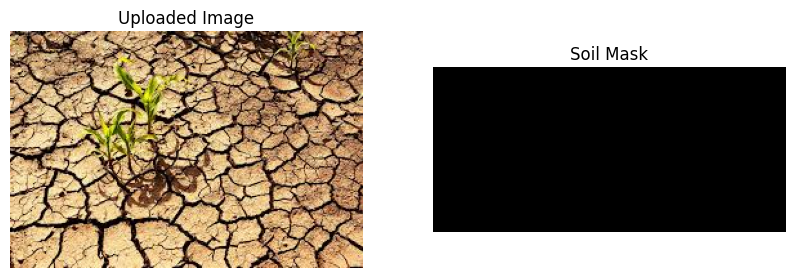

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Uploaded Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title('Soil Mask')
plt.axis('off')
plt.show()

# **RandomForest classifier prediction trained on first dataset**

In [ ]:
def moisture_label(moisture_score):
    if moisture_score > 0.7:
        return "High"
    elif moisture_score < 0.4:
        return "Low"
    else:
        return "Moderate"

mask = segment_soil(image)
color_features = extract_color_features(image, mask)
moisture_score, gloss_score, darkness_score = estimate_moisture(image, mask)
color_features['moisture_score'] = moisture_score
color_features['gloss_score'] = gloss_score
color_features['darkness_score'] = darkness_score

X_test = pd.DataFrame([color_features])
with open('/content/drive/MyDrive/soil_data/model.pkl', 'rb') as f:
    model = pickle.load(f)
pred = model.predict(X_test)[0]
moisture_lvl = moisture_label(moisture_score)
print(f'Predicted Soil Quality: {pred}')
print(f'Estimated Moisture Score: {moisture_score:.2f} ({moisture_lvl})')
print('Recommendations:')
for i, rec in enumerate(get_recommendations(pred, moisture_score), 1):
    print(f'{i}. {rec}')

Predicted Soil Quality: Poor
Estimated Moisture Score: 0.35 (Low)
Recommendations:
1. Add organic matter (compost or manure)
2. Consider soil testing for specific nutrient deficiencies
3. Implement crop rotation practices
4. Implement irrigation system
5. Add mulch to retain moisture
6. Consider drought-resistant crops


# **XGB classifier prediction trained on second dataset**

In [ ]:
def moisture_label(moisture_score):
    if moisture_score > 0.7:
        return "High"
    elif moisture_score < 0.4:
        return "Low"
    else:
        return "Moderate"

mask = segment_soil(image)
color_features = extract_color_features(image, mask)
moisture_score, gloss_score, darkness_score = estimate_moisture(image, mask)
color_features['moisture_score'] = moisture_score
color_features['gloss_score'] = gloss_score
color_features['darkness_score'] = darkness_score

X_test = pd.DataFrame([color_features])
with open('/content/drive/MyDrive/data1/model1.pkl', 'rb') as f:
    model = pickle.load(f)
pred = model.predict(X_test)[0]

pred = le.inverse_transform([pred])[0]

moisture_lvl = moisture_label(moisture_score)
print(f'Predicted Soil Quality: {pred}')
print(f'Estimated Moisture Score: {moisture_score:.2f} ({moisture_lvl})')
print('Recommendations:')
for i, rec in enumerate(get_recommendations(pred, moisture_score), 1):
    print(f'{i}. {rec}')

Predicted Soil Quality: Poor
Estimated Moisture Score: 0.35 (Low)
Recommendations:
1. Add organic matter (compost or manure)
2. Consider soil testing for specific nutrient deficiencies
3. Implement crop rotation practices
4. Implement irrigation system
5. Add mulch to retain moisture
6. Consider drought-resistant crops
